In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

import json
import gensim
from gensim.models import Word2Vec, KeyedVectors

from sklearn.metrics import accuracy_score, classification_report, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/OBRADA PRIRODNOG JEZIKA/PROJEKT/

/content/drive/MyDrive/OBRADA PRIRODNOG JEZIKA/PROJEKT


In [4]:
!pip install datasets

In [6]:
#load hr500k dataset from Hugging Face, classla repository
from datasets import load_dataset

dataset = load_dataset("classla/hr500k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for classla/hr500k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/classla/hr500k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.w

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
# split train, validation and test subsets
# tokens column is our input data and xpos_tags column is our target data

train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

X_train = train_data['tokens']
Y_train = train_data['xpos_tags']
X_valid = validation_data['tokens']
Y_valid = validation_data['xpos_tags']
X_test = test_data['tokens']
Y_test = test_data['xpos_tags']

In [8]:
# Tokenize and pad sequences for test data as it was done for training and validation
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train + X_valid + X_test)
xpos_tokenizer = Tokenizer()
xpos_tokenizer.fit_on_texts(Y_train + Y_valid + Y_test)

MAX_SEQ_LENGTH = 100
X_test_encoded = word_tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

Y_test_xpos_encoded = xpos_tokenizer.texts_to_sequences(Y_test)
Y_test_xpos_padded = pad_sequences(Y_test_xpos_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

In [9]:
%pwd

'/content/drive/MyDrive/OBRADA PRIRODNOG JEZIKA/PROJEKT'

In [10]:
# load saved model
bidirect_model = load_model('bidir_lstm.h5')

In [11]:
# display a summary of the model architecture to check if it is loaded as expected
bidirect_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          20039400  
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          186880    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 769)          99201     
 ributed)                                                        
                                                                 
Total params: 20325481 (77.54 MB)
Trainable params: 20325481 (77.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# load saved history of the model training
bidirect_history = json.load(open('bidir_train_history.json', 'r'))

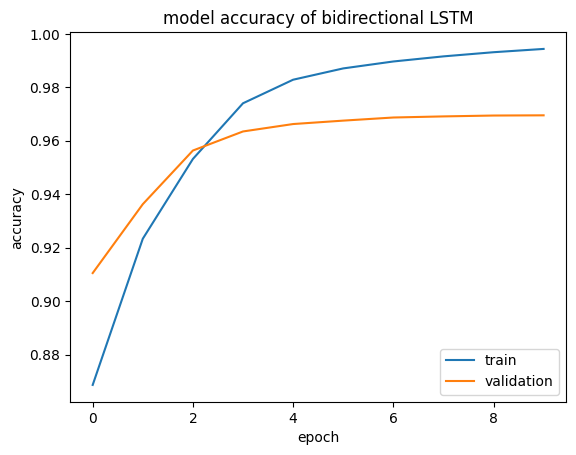

In [13]:
# plot accuracy
plt.plot(bidirect_history['acc'])
plt.plot(bidirect_history['val_acc'])
plt.title('model accuracy of bidirectional LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.savefig("acc-bidir-lstm.png")
plt.show()

In [14]:
# Assuming you have predictions for test data
Y_test_pred = bidirect_model.predict(X_test_padded)

# Reshape predictions and ground truth for accuracy calculation
Y_test_pred_flat = np.argmax(Y_test_pred, axis=-1).flatten()
Y_test_true_flat = Y_test_xpos_padded.flatten()

# Calculate accuracy
test_accuracy = accuracy_score(Y_test_true_flat, Y_test_pred_flat)

print("Test Accuracy:", test_accuracy)

84/84 [==============================] - 2s 6ms/step
Test Accuracy: 0.968873502994012


In [15]:
# generate a text report showing the main classification metrics such as precision, recall, F1-score, and support
print(classification_report(Y_test_true_flat, Y_test_pred_flat))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    216016
           1       1.00      1.00      1.00      6734
           2       0.89      0.92      0.91      2349
           3       0.93      0.96      0.95      2275
           4       0.97      1.00      0.99      1785
           5       0.97      0.92      0.95      1744
           6       0.95      0.93      0.94      1514
           7       0.83      0.92      0.88      1225
           8       0.88      0.95      0.91      1149
           9       0.98      0.97      0.97      1230
          10       0.79      0.74      0.77      1125
          11       0.82      0.85      0.84       940
          12       0.84      0.81      0.82       928
          13       0.92      0.86      0.89       822
          14       0.38      0.68      0.49       840
          15       0.90      0.77      0.83       867
          16       1.00      1.00      1.00       747
          17       0.81    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [16]:
print("F1 score (weighted): ",f1_score(Y_test_true_flat, Y_test_pred_flat, average='weighted')) #'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).

F1 score (weighted):  0.9687884169648882


In [17]:
print("F1 score (macro): ",f1_score(Y_test_true_flat, Y_test_pred_flat, average='macro')) #macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

F1 score (macro):  0.5197681999071828


In [18]:
print("F1 score (micro): ",f1_score(Y_test_true_flat, Y_test_pred_flat, average='micro')) #micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.

F1 score (micro):  0.9688735029940119


In [19]:
# Assuming you have predictions for test data
Y_test_pred = bidirect_model.predict(X_test_padded)

# Convert one-hot encoded predictions back to integer labels
Y_test_pred_labels = np.argmax(Y_test_pred, axis=-1)

# Convert integer labels back to the original label space
Y_test_pred_original = xpos_tokenizer.sequences_to_texts(Y_test_pred_labels)
Y_test_true_original = xpos_tokenizer.sequences_to_texts(Y_test_xpos_padded)

print("Input:", X_test[0])

print("True labels:", Y_test_true_original[0])

print("Predicted labels:", Y_test_pred_original[0])

84/84 [==============================] - 0s 6ms/step
Input: ['Poslovanje', ':', 'Istraživanje', 'pokazuje', 'kako', 'raste', 'broj', 'Europljana', 'suočenih', 'sa', 'siromaštvom']
True labels: ncnsn z ncnsn vmr3s cs vmr3s ncmsn npmpg appmpgy si ncnsi
Predicted labels: ncnsn z ncnsn vmr3s cs vmr3s ncmsn appfpgy ncmpg sg ncnsi


In [20]:
# Display token, true label, and predicted label for the first 10 samples
num_samples_to_display = min(10, len(X_test))
for i in range(num_samples_to_display):
    print(f"Sample {i + 1}:\n")

    input_sequence = X_test[i]
    true_labels = Y_test_true_original[i].split()
    predicted_labels = Y_test_pred_original[i].split()

    # Print headers
    print(f"{'Token'.ljust(15)}{'True'.ljust(10)}{'Predicted'}")

    for token, true_label, predicted_label in zip(input_sequence, true_labels, predicted_labels):
        print(f"{token.ljust(15)}{true_label.ljust(10)}{predicted_label}")
    print("\n" + "-"*50 + "\n")  # Line between samples

Sample 1:

Token          True      Predicted
Poslovanje     ncnsn     ncnsn
:              z         z
Istraživanje   ncnsn     ncnsn
pokazuje       vmr3s     vmr3s
kako           cs        cs
raste          vmr3s     vmr3s
broj           ncmsn     ncmsn
Europljana     npmpg     appfpgy
suočenih       appmpgy   ncmpg
sa             si        sg
siromaštvom    ncnsi     ncnsi

--------------------------------------------------

Sample 2:

Token          True      Predicted
Više           rgc       rgc
od             sg        sg
dvije          mlcf-n    mlcf-n
trećine        ncfpg     ncfpn
Grka           npmpg     npmpg
kaže           vmr3s     vmr3s
kako           cs        cs
su             var3p     var3p
postali        vmp-pm    vmp-pm
siromašniji    agcmpny   ncmpn
,              z         z
a              cc        cc
slični         agpmpny   agpmpny
se             px--sa    px--sa
rezultati      ncmpn     ncmpn
bilježe        vmr3p     vmr3p
i              cc        cc
u       